Objectif : fine-tuning + modèle final + explications

Méthodologie : StratifiedKFold, scoring = PR-AUC (average precision), pourquoi

GridSearch : LogReg + RandomForest

Évaluation test + choix seuil

Feature importance globale : permutation importance

SHAP global : beeswarm

SHAP local : waterfall sur 2–3 individus

Synthèse : causes potentielles + limites + next steps

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

from technova_attrition.config import PATHS, SETTINGS
from technova_attrition.evaluation import (
    evaluate_classifier,
    find_threshold_for_recall,
    plot_precision_recall,
)
from technova_attrition.modeling import make_logreg, make_random_forest
from technova_attrition.preprocessing import FeatureGroups
from technova_attrition.tuning import run_grid_search, summarize_grid_search

df = pd.read_parquet(PATHS.data_processed / "employees_features.parquet")

TARGET = "a_quitte_l_entreprise"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SETTINGS.random_state,
    stratify=y,
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SETTINGS.random_state)
y.value_counts(normalize=True).round(3)

a_quitte_l_entreprise
0    0.839
1    0.161
Name: proportion, dtype: float64

In [2]:
# === Numériques ===
num_cont = [
    "age",
    "augmentation_salaire_precedente",
    "distance_domicile_travail",
    "proba_chgt_experience_par_an",
    "proba_chgt_experience_par_an_adulte",
    "ratio_experience_vie_adulte",
]

num_log = [
    "revenu_mensuel",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "annees_depuis_la_derniere_promotion",
]

num_disc = [
    "nombre_participation_pee",
    "nb_formations_suivies",
    "nombre_employee_sous_responsabilite",
    "nombre_experiences_precedentes",
    "nombre_experiences_precedents",
]

# === Binaires ===
bin_cols = ["genre", "heure_supplementaires", "changement_poste"]

# === Nominales ===
cat_nom = ["statut_marital", "departement", "poste", "domaine_etude"]

# === Ordinales ===
cat_ord = [
    "satisfaction_employee_environnement",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_precedente",
    "note_evaluation_actuelle",
    "niveau_hierarchique_poste",
    "niveau_education",
    "frequence_deplacement",
    "evolution_note",
]


# Nettoyage automatique : on ne garde que les colonnes présentes
def keep_existing(cols):
    return [c for c in cols if c in X.columns]


num_cont = keep_existing(num_cont)
num_log = keep_existing(num_log)
num_disc = keep_existing(num_disc)
bin_cols = keep_existing(bin_cols)
cat_nom = keep_existing(cat_nom)
cat_ord = keep_existing(cat_ord)

# Ordres ordinal : par défaut, on prend l’ordre trié (tu pourras le remplacer par un ordre métier explicite)
ord_categories = [sorted(df[c].dropna().unique().tolist()) for c in cat_ord]

groups = FeatureGroups(
    num_cont=num_cont,
    num_log=num_log,
    num_disc=num_disc,
    bin_cols=bin_cols,
    cat_nom=cat_nom,
    cat_ord=cat_ord,
    ord_categories=ord_categories,
)

groups

FeatureGroups(num_cont=['age', 'distance_domicile_travail', 'proba_chgt_experience_par_an', 'proba_chgt_experience_par_an_adulte', 'ratio_experience_vie_adulte'], num_log=['revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'annees_depuis_la_derniere_promotion'], num_disc=['nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'nombre_experiences_precedentes'], bin_cols=['genre', 'heure_supplementaires', 'changement_poste'], cat_nom=['statut_marital', 'departement', 'poste', 'domaine_etude'], cat_ord=['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_precedente', 'note_evaluation_actuelle', 'niveau_hierarchique_poste', 'niveau_education', 'frequence_deplacement', 'evolution_note'], ord_categories=[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2,

In [3]:
logreg_pipe = make_logreg(groups)

param_grid_logreg = {
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.2, 0.5, 0.8],  # utilisé seulement si elasticnet
}

gs_logreg = run_grid_search(
    pipeline=logreg_pipe,
    param_grid=param_grid_logreg,
    X_train=X_train,
    y_train=y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1,
)

summary_logreg = summarize_grid_search(gs_logreg)
summary_logreg.head(10)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score,params
26,1,0.634435,0.030873,0.684733,0.010774,"{'model__C': 1.0, 'model__l1_ratio': 0.8, 'mod..."
21,2,0.634421,0.029880,0.685040,0.011200,"{'model__C': 1.0, 'model__l1_ratio': 0.5, 'mod..."
18,2,0.634421,0.029880,0.685049,0.011181,"{'model__C': 1.0, 'model__l1_ratio': 0.2, 'mod..."
24,2,0.634421,0.029880,0.685037,0.011199,"{'model__C': 1.0, 'model__l1_ratio': 0.8, 'mod..."
20,5,0.633770,0.030577,0.685416,0.010875,"{'model__C': 1.0, 'model__l1_ratio': 0.2, 'mod..."
25,6,0.633335,0.032888,0.684329,0.010847,"{'model__C': 1.0, 'model__l1_ratio': 0.8, 'mod..."
22,6,0.633335,0.032888,0.684317,0.010840,"{'model__C': 1.0, 'model__l1_ratio': 0.5, 'mod..."
19,8,0.633322,0.032909,0.684321,0.010845,"{'model__C': 1.0, 'model__l1_ratio': 0.2, 'mod..."
12,9,0.632827,0.019938,0.678173,0.013312,"{'model__C': 0.1, 'model__l1_ratio': 0.5, 'mod..."
15,9,0.632827,0.019938,0.678162,0.013296,"{'model__C': 0.1, 'model__l1_ratio': 0.8, 'mod..."


In [4]:
rf_pipe = make_random_forest(groups)

param_grid_rf = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [None, 6, 10],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", 0.5],
}

gs_rf = run_grid_search(
    pipeline=rf_pipe,
    param_grid=param_grid_rf,
    X_train=X_train,
    y_train=y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1,
)

summary_rf = summarize_grid_search(gs_rf)
summary_rf.head(10)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score,params
1,1,0.561713,0.058633,1.000000,1.216188e-16,"{'model__max_depth': None, 'model__max_feature..."
33,2,0.555315,0.045501,0.961473,7.997655e-03,"{'model__max_depth': 10, 'model__max_features'..."
9,3,0.554800,0.045829,0.962950,8.777957e-03,"{'model__max_depth': None, 'model__max_feature..."
0,4,0.554188,0.058847,1.000000,1.570092e-16,"{'model__max_depth': None, 'model__max_feature..."
14,5,0.553949,0.050743,0.837563,4.343189e-03,"{'model__max_depth': 6, 'model__max_features':..."
27,6,0.553906,0.048588,0.927509,7.908148e-03,"{'model__max_depth': 10, 'model__max_features'..."
3,7,0.552418,0.047846,0.933402,8.742587e-03,"{'model__max_depth': None, 'model__max_feature..."
26,8,0.552061,0.053248,0.927256,8.508695e-03,"{'model__max_depth': 10, 'model__max_features'..."
2,9,0.551049,0.052203,0.932979,7.851055e-03,"{'model__max_depth': None, 'model__max_feature..."
15,10,0.550260,0.043149,0.838162,4.910156e-03,"{'model__max_depth': 6, 'model__max_features':..."


In [5]:
best_logreg = gs_logreg.best_estimator_
best_rf = gs_rf.best_estimator_

res_logreg = evaluate_classifier(best_logreg, X_train, y_train, X_test, y_test, threshold=0.5)
res_rf = evaluate_classifier(best_rf, X_train, y_train, X_test, y_test, threshold=0.5)

print("LogReg AP test:", res_logreg["test_ap"])
print("RF AP test:", res_rf["test_ap"])
print("\nLogReg report:\n", res_logreg["test_report"])
print("\nRF report:\n", res_rf["test_report"])

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


LogReg AP test: 0.5535963849691297
RF AP test: 0.37716349829859186

LogReg report:
               precision    recall  f1-score   support

           0      0.929     0.798     0.858       247
           1      0.390     0.681     0.496        47

    accuracy                          0.779       294
   macro avg      0.660     0.739     0.677       294
weighted avg      0.843     0.779     0.800       294


RF report:
               precision    recall  f1-score   support

           0      0.850     0.964     0.903       247
           1      0.357     0.106     0.164        47

    accuracy                          0.827       294
   macro avg      0.604     0.535     0.534       294
weighted avg      0.771     0.827     0.785       294



0.3425620140675777

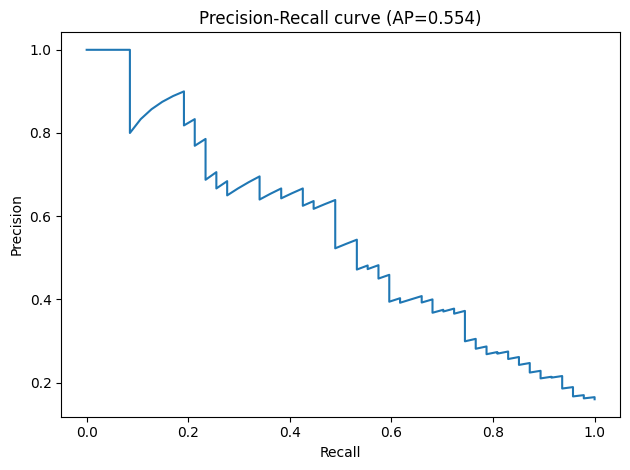

In [6]:
final_model = best_logreg  # ou best_rf si clairement meilleur + cohérent
p_test = final_model.predict_proba(X_test)[:, 1]

plot_precision_recall(y_test, p_test)

thr = find_threshold_for_recall(y_test, p_test, target_recall=0.80)
thr

In [7]:
res_thr = evaluate_classifier(final_model, X_train, y_train, X_test, y_test, threshold=thr)
print(res_thr["test_report"])
print(res_thr["test_cm"])

              precision    recall  f1-score   support

           0      0.942     0.591     0.726       247
           1      0.273     0.809     0.409        47

    accuracy                          0.626       294
   macro avg      0.608     0.700     0.567       294
weighted avg      0.835     0.626     0.676       294

[[146 101]
 [  9  38]]


g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [8]:
from technova_attrition.explainability import permutation_importance_df

perm_df = permutation_importance_df(
    final_model, X_test, y_test, scoring="average_precision", n_repeats=20
)
perm_df.head(20)

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,feature,importance_mean,importance_std
18,heure_supplementaires,0.217938,0.027662
7,annee_experience_totale,0.116213,0.041992
13,satisfaction_employee_nature_travail,0.069270,0.016255
6,nombre_experiences_precedentes,0.068146,0.014815
29,annees_depuis_la_derniere_promotion,0.058064,0.020466
10,satisfaction_employee_environnement,0.054004,0.026000
12,niveau_hierarchique_poste,0.031277,0.026860
2,revenu_mensuel,0.026066,0.018066
11,note_evaluation_precedente,0.021389,0.018677
14,satisfaction_employee_equipe,0.019793,0.011511


In [9]:
perm_path = PATHS.reports / "permutation_importance.csv"
perm_df.to_csv(perm_path, index=False)
perm_path

WindowsPath('G:/Mon Drive/OC/Projet_4/technova_attrition/reports/permutation_importance.csv')

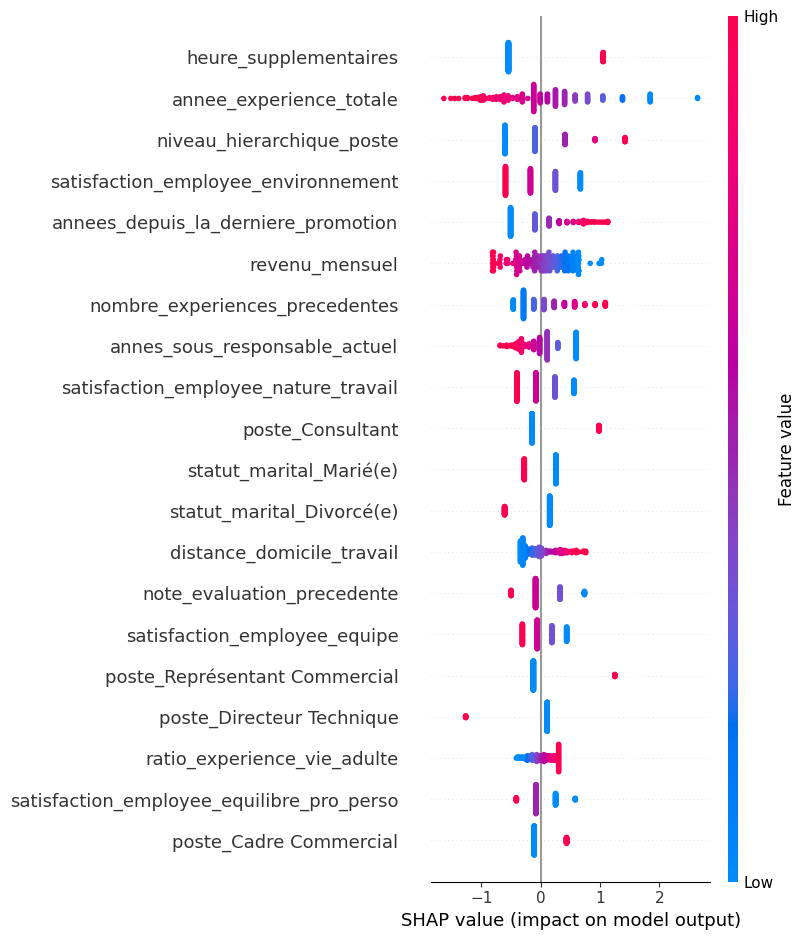

In [10]:
import shap

from technova_attrition.explainability import shap_explain_linear_model

# background = petit échantillon pour stabilité
X_bg = X_train.sample(min(200, len(X_train)), random_state=SETTINGS.random_state)
X_exp = X_test.sample(min(200, len(X_test)), random_state=SETTINGS.random_state)

explainer, shap_values, X_exp_t, feature_names = shap_explain_linear_model(final_model, X_bg, X_exp)

# Global beeswarm
shap.summary_plot(shap_values, X_exp_t, feature_names=feature_names)

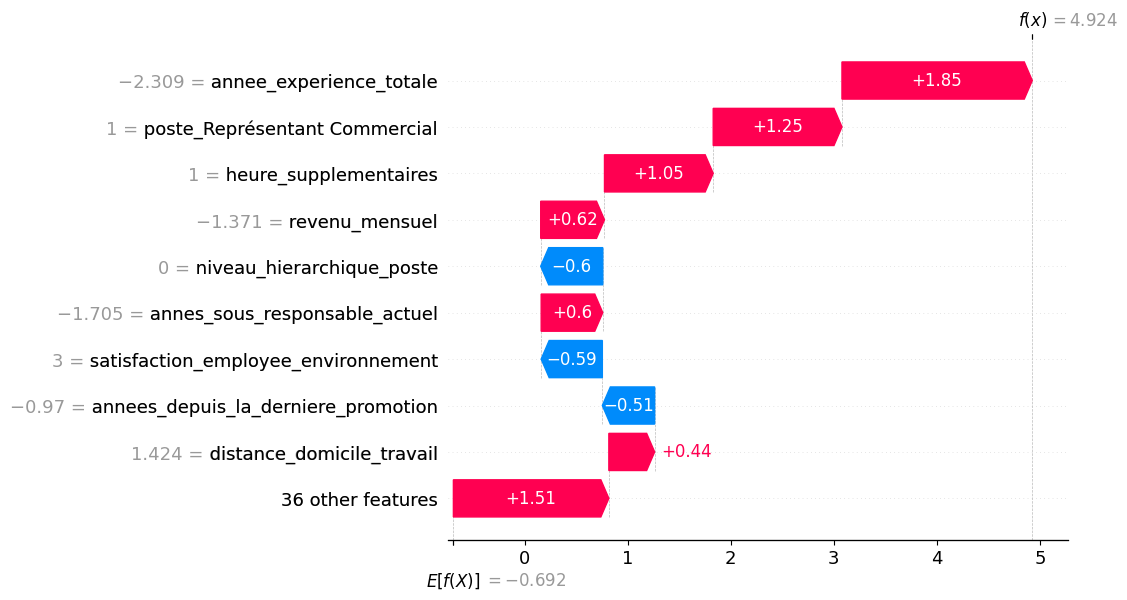

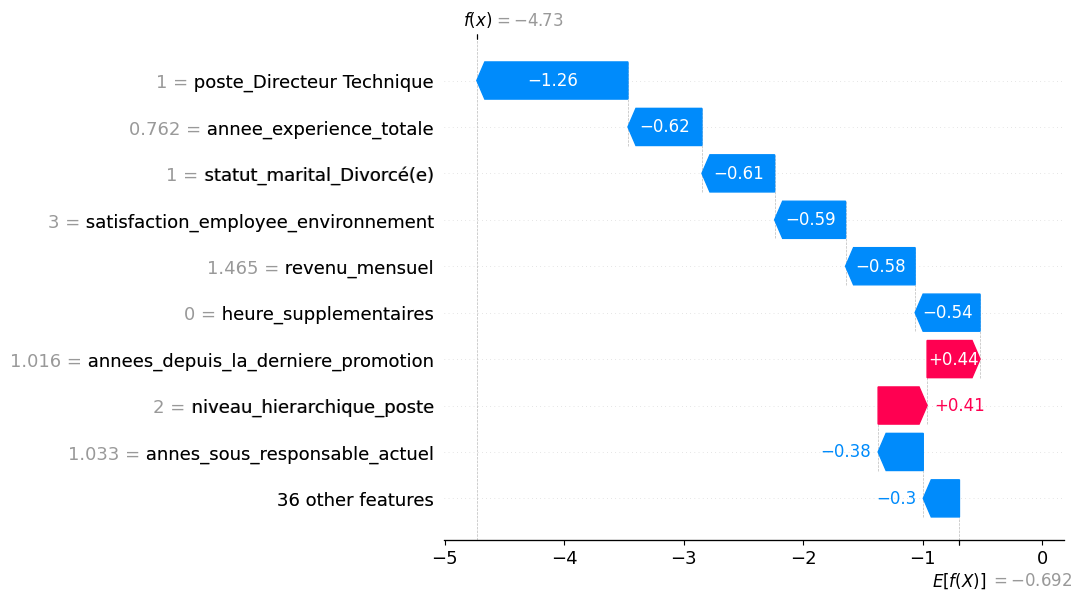

In [11]:
probas = final_model.predict_proba(X_test)[:, 1]
idx_high = probas.argmax()
idx_low = probas.argmin()

X_one_high = X_test.iloc[[idx_high]]
X_one_low = X_test.iloc[[idx_low]]

# Transform + shap values pour 1 point
Xb = X_bg
explainer, shap_vals_high, Xh_t, fn = shap_explain_linear_model(final_model, Xb, X_one_high)
explainer, shap_vals_low, Xl_t, fn = shap_explain_linear_model(final_model, Xb, X_one_low)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_vals_high[0],
        base_values=explainer.expected_value,
        data=Xh_t[0],
        feature_names=fn,
    )
)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_vals_low[0],
        base_values=explainer.expected_value,
        data=Xl_t[0],
        feature_names=fn,
    )
)

In [12]:
import joblib

model_path = PATHS.models / "final_model.joblib"
joblib.dump(final_model, model_path)
model_path

WindowsPath('G:/Mon Drive/OC/Projet_4/technova_attrition/models/final_model.joblib')

In [13]:
import json

metrics = {
    "threshold": float(thr),
    "test_ap": float(res_thr["test_ap"]),
    "test_roc_auc": float(res_thr["test_roc_auc"]),
}

metrics_path = PATHS.reports / "final_metrics.json"
metrics_path.write_text(json.dumps(metrics, indent=2))
metrics_path

WindowsPath('G:/Mon Drive/OC/Projet_4/technova_attrition/reports/final_metrics.json')